## Annoted diffusion models
Notebook created by Frédéric Charbonnier & Joel Clerc as part of the Master IS research project "Learning to generate
molecules".

### Introduction

The objective of this notebook is to experiment and implemente the Denoising Diffusion Probabilistic Models (DDPMs) initialized by [Sohl-Dickstein et al](http://arxiv.org/abs/1503.03585), proposed by [Ho. et al](http://arxiv.org/abs/2006.11239) and improved by [Nichol, Dhariwal](http://arxiv.org/abs/2102.09672). The code used comes from [Phil Wang's GitHub](https://github.com/lucidrains/denoising-diffusion-pytorch) and [Niels Rogge and Kashif Rasul's blog post](https://huggingface.co/blog/annotated-diffusion). Theoretical support by [Karagiannakos, Adaloglou](https://theaisummer.com/diffusion-models/).

The diffusion process gradually adds Gaussian noise to the input data (**forward diffusion**), then reverses the process (**reverse diffusion**) to recover the data. A neural network is trained to learn how to progressively remove the noise. Once trained, the neural network can generate samples corresponding to the distribution of the input data.

### Libraries

The following libraries are required for implementation.

In [2]:
#!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Forward diffusion

Given a data distribution $x_{0} ∼ q(x_{0})$, we define a forward noising process q which produces latents $x_{1}$ through $x_{T}$ by adding Gaussian noise at time t with variance $\beta_{t}$ as follows:  

$\beta_{t} ∈ (0, 1)$ 

$q(x_{1:T}|x_{0})=\prod_{t=1}^{T}q(x_{t}|x_{t-1}) \\q(x_{t}|x_{t-1})=\mathcal{N}(x_{t};\sqrt{1-\beta_{t}}x_{t-1},\beta_{t}I)$

This noising process allows us to sample an arbitrary step of the noised latents directly conditioned on the input $x_{0}$. 
We can write the marginal equation :  

$\alpha_{t}=1-\beta_{t} \\\bar{\alpha}_{t}=\prod_{t=1}^{T}\alpha_{t} \\\epsilon = \mathcal{N}(0;I)$

$q(x_{t}|x_{0})=\mathcal{N}(x_{t};\sqrt{\bar{\alpha}_{t}}x_{0},(1-\bar{\alpha}_{t})I)\\  
x_{t} =\sqrt{\bar{\alpha}_{t}}x_{0}+\sqrt{1-\bar{\alpha}_{t}}\epsilon$



[Ho. et al](http://arxiv.org/abs/2006.11239) used linear schedule for variance $\beta_{t}$. [Nichol, Dhariwal](http://arxiv.org/abs/2102.09672) obtained better results with a cosine schedule.  
We define 4 various schedules for the T timesteps.

In [3]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


We define the T timesteps

In [4]:
timesteps = 300

We pre-calculate various useful variables for the forward diffusion :

$\beta_{t}$= linear schedule  
$\alpha_{t}=1-\beta_{t} \\\bar{\alpha}_{t}=\prod_{t=1}^{T}\alpha_{t}$

In [5]:
# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

We define an extract function, which will allow us to extract the appropriate 
$t$ index for a batch of indices

In [6]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

We define the forward diffusion process :  

$q(x_{t}|x_{0})=\mathcal{N}(x_{t};\sqrt{\bar{\alpha}_{t}}x_{0},(1-\bar{\alpha}_{t})I)\\  
x_{t} =\sqrt{\bar{\alpha}_{t}}x_{0}+\sqrt{1-\bar{\alpha}_{t}}\epsilon$

Parameter x_start = $x_{0}$

In [7]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

#### Test forward process

We import a test image

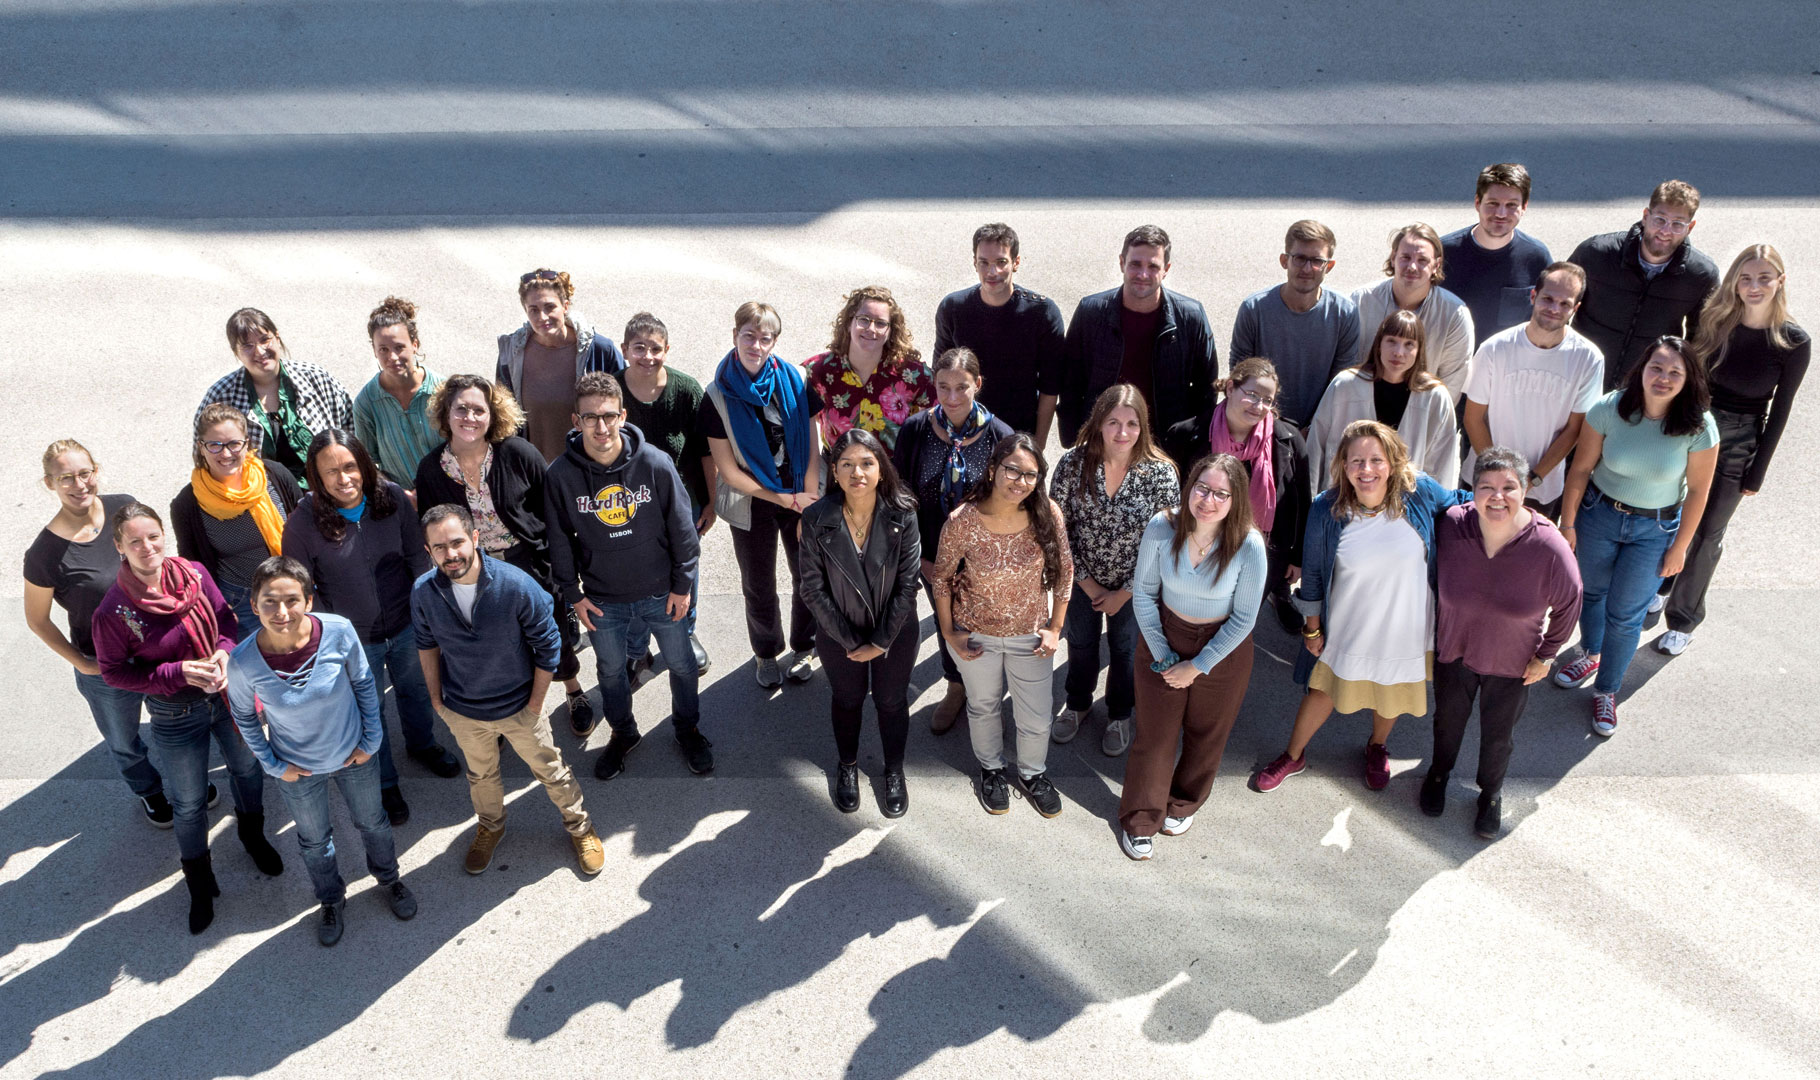

In [8]:
from PIL import Image
import requests

url = 'https://www.hesge.ch/heg/sites/default/files/actualite/banniere/2022-master-is-rentree-banner.jpg'
image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
image

We define a transformation step with the following actions:
- Resize the image
- Crop the image to the centre
- Transforms to Tensor
- Normalise the values between [-1,1]

In [9]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

We test the transformation

In [10]:
x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

We define the reverse transformation

In [11]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

We test the reverse transformation

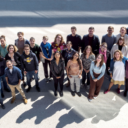

In [12]:
reverse_transform(x_start.squeeze())

We define a function to obtain a noisy image for a particular time step

In [13]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

We test this function

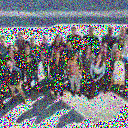

In [14]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

We define a function to plot several images

In [15]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

We plot noisy images with various time step

In [16]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

### Reverse process

We approximate $q(x_{t-1}|x_{t})$ with a parameterized model $p_\theta$ as follows:  

$p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$

By additionally conditioning the model on timestep $t$, it will learn to predict the Gaussian parameters (meaning the mean $\boldsymbol{\mu}_\theta(\mathbf{x}_t, t)$ and the covariance matrix $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)$) for each timestep.

Note that [Ho. et al](http://arxiv.org/abs/2006.11239) decided to keep the variance fixed and to have the network learn only the mean.  
​  
If we apply the reverse formula for all timesteps, we can go from $T$ to the data distribution:

$p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$
  
[Ho. et al](http://arxiv.org/abs/2006.11239) show that we can reparameterise the mean so that the neural network directly learns the added noise $\epsilon_\theta(\mathbf{x}_{t} \vert t)$ for noise level $t$:

$\boldsymbol{\mu}_\theta(\mathbf{x}_{t},t) = \frac{1}{\sqrt{\alpha_{t}}}(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}}\epsilon_\theta(\mathbf{x}_{t},t))$
  
To train the neural network, [Ho. et al](http://arxiv.org/abs/2006.11239) propose to use the following loss function:  
  
$L = ||\epsilon - \epsilon_\theta(\mathbf{x}_{t},t)||^2 = ||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{(1-\bar{\alpha}_{t})}\epsilon,t)||^2$

As a reminder, in the forward process: $x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0}+\sqrt{1-\bar{\alpha}_{t}}\epsilon$
  
The neural network is optimized using a simple mean squared error (MSE) between the true ($\epsilon$) and the predicted ($\epsilon_\theta$) Gaussian noise.

#### Neural network

To learn $\epsilon_\theta(\mathbf{x}_{t} \vert t)$, [Ho. et al](http://arxiv.org/abs/2006.11239) uses a convolutional neural network called U-net.  
One of the advantages of this architecture is that the input and output are the same size.  
With $x_{t}$ as input, the output will be the same size as $x_{t}$.

For the neural network knows at which particular time step it is operating, $t$ is encoded with the sinusoidal position embeddings.

In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


We define some helper functions and classes which will be used when implementing the neural network.

In [18]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


We define the core building block of the U-Net model with a Wide ResNet block, a weight standardized convolutional layer with group normalization.

In [19]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, classes_emb_dim = None, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(int(time_emb_dim) + int(classes_emb_dim), dim_out * 2)
        ) if exists(time_emb_dim) or exists(classes_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None, class_emb = None):
        scale_shift = None
        if exists(self.mlp) and (exists(time_emb) or exists(class_emb)):
            cond_emb = tuple(filter(exists, (time_emb, class_emb)))
            cond_emb = torch.cat(cond_emb, dim = -1)
            cond_emb = self.mlp(cond_emb)
            cond_emb = rearrange(cond_emb, 'b c -> b c 1 1')
            scale_shift = cond_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


We define the attention module, added in between the convolutional blocks

In [20]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


We interleave the convolutional/attention layers of the U-Net with group normalization.

In [21]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

Classifier free guidance functions

In [22]:
def uniform(shape, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1)

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

We define the entire Conditional U-Net by assembling position embeddings, ResNet blocks, attention and group normalization.

In [23]:
class UnetConditional(nn.Module):
    def __init__(
        self,
        dim,
        num_classes,
        cond_drop_prob = 0.5,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # classifier free guidance stuff

        self.cond_drop_prob = cond_drop_prob

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # class embeddings

        self.classes_emb = nn.Embedding(num_classes, dim)
        self.null_classes_emb = nn.Parameter(torch.randn(dim))

        classes_dim = dim * 4

        self.classes_mlp = nn.Sequential(
            nn.Linear(dim, classes_dim),
            nn.GELU(),
            nn.Linear(classes_dim, classes_dim)
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim, classes_emb_dim = classes_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim, classes_emb_dim = classes_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, classes_emb_dim = classes_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, classes_emb_dim = classes_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim, classes_emb_dim = classes_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim, classes_emb_dim = classes_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim, classes_emb_dim = classes_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)
    
    # Adds classifier-free guidance to the forward pass
    # Conditioning scale.
    # cond_scale = 0 => unconditional model.
    # cond_scale = 1 => standard conditional model.
    # cond_scale > 1 => large guidance weights improve image quality/fidelity at the cost of diversity.
    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        rescaled_phi = 0.,
        **kwargs
    ):
        logits = self.forward(*args, cond_drop_prob = 0., **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        scaled_logits = null_logits + (logits - null_logits) * cond_scale

        if rescaled_phi == 0.:
            return scaled_logits

        std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
        rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))

        return rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

    def forward(self, x, time, classes, cond_drop_prob = None, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)
        
        batch, device = x.shape[0], x.device

        cond_drop_prob = default(cond_drop_prob, self.cond_drop_prob)

        # derive condition, with condition dropout for classifier free guidance        

        classes_emb = self.classes_emb(classes)

        if cond_drop_prob > 0:
            keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)
            null_classes_emb = repeat(self.null_classes_emb, 'd -> b d', b = batch)

            classes_emb = torch.where(
                rearrange(keep_mask, 'b -> b 1'),
                classes_emb,
                null_classes_emb
            )

        c = self.classes_mlp(classes_emb)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t, c)
        return self.final_conv(x)


#### Loss function

We define the MSE loss function: 
   
$L = ||\epsilon - \epsilon_\theta(\mathbf{x}_{t},t)||^2$  

And 2 others loss types.

In [24]:
def p_losses(denoise_model, x_start, t, classes, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, classes)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

#### Sampling functions

A PRECISER   
We define the function for calculating the sample using $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$.

$\boldsymbol{\mu}_\theta(\mathbf{x}_{t},t) = \frac{1}{\sqrt{\alpha_{t}}}(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}}\epsilon_\theta(\mathbf{x}_{t},t))$

$\mathbf{x}_{t-1} = \boldsymbol{\mu}_\theta(\mathbf{x}_{t},t) + \beta_{t}\epsilon$

And the function $p_\theta(\mathbf{x}_{0:T})$ to go from $T$ to the data distribution :

$p_\theta(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

In [25]:
@torch.no_grad()
def p_sample(model, x, t, t_index, classes, cond_scale = 6., rescaled_phi = 0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model.forward_with_cond_scale(x, t, classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, cond_scale, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, classes, cond_scale=cond_scale)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, classes, image_size, cond_scale=6., batch_size=16, channels=3):
    return p_sample_loop(model, classes, cond_scale, shape=(batch_size, channels, image_size, image_size))


### Training

A PRECISER

We define a datasets (fashion mnist) and various parameters

In [26]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("mnist")
#dataset = load_dataset("mnist")
image_size = 28
num_classes = 10
channels = 1
#batch_size = 128
batch_size = 64

We define a function of image preprocessing

In [27]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

We applied image preprocessing to dataset and create a dataloader

In [28]:
#transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
transformed_dataset = dataset.with_transform(transforms)

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

We create a batch

In [29]:
batch = next(iter(dataloader))
print(batch.keys())


dict_keys(['label', 'pixel_values'])


We define some logic to periodically save generated images

In [30]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 300

We define the model, move it to the GPU and define a Adam optimizer.

In [31]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = UnetConditional(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    num_classes=num_classes
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


cuda


We start training

In [32]:
from torchvision.utils import save_image

epochs = 3

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      classes = batch["label"].to(device)
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, classes, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        nb_images = 60
        images_classes = torch.tensor([i // (nb_images//10) for i in range(nb_images)]).cuda()
        batches = num_to_groups(nb_images, batch_size)
        # unconditional
        all_images_list = list(map(lambda n: sample(model, images_classes, image_size=image_size, cond_scale=0, batch_size=n, channels=channels)[-1], batches))
        all_images = torch.cat([torch.from_numpy(img) for img in all_images_list], dim = 0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'unconditional-{epoch}-{milestone}.png'), nrow = 6)
        # conditional
        all_images_list = list(map(lambda n: sample(model, images_classes, image_size=image_size,  cond_scale=6., batch_size=n, channels=channels)[-1], batches))
        all_images = torch.cat([torch.from_numpy(img) for img in all_images_list], dim = 0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'conditional-{epoch}-{milestone}.png'), nrow = 6)

Loss: 0.7465684413909912
Loss: 0.060464225709438324
Loss: 0.03719047084450722
Loss: 0.026533309370279312


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 25.49it/s]


Loss: 0.029297176748514175
Loss: 0.02919917181134224
Loss: 0.02506324090063572


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 25.38it/s]


Loss: 0.02383006364107132
Loss: 0.01981339044868946
Loss: 0.02357892133295536


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 25.96it/s]


Loss: 0.022325996309518814
Loss: 0.022175299003720284
Loss: 0.020733827725052834
Loss: 0.02413993701338768


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 26.22it/s]


Loss: 0.0193625595420599
Loss: 0.022014349699020386
Loss: 0.02346869371831417


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 26.19it/s]


Loss: 0.020590178668498993
Loss: 0.02079719677567482
Loss: 0.024249276146292686


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 25.95it/s]


Loss: 0.01994645968079567
Loss: 0.019885042682290077
Loss: 0.02015099860727787
Loss: 0.021651048213243484


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 26.23it/s]


Loss: 0.021408217027783394
Loss: 0.018879041075706482
Loss: 0.023376362398266792


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 26.28it/s]


Loss: 0.02008817344903946
Loss: 0.02421327494084835
Loss: 0.02058766596019268


sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 26.27it/s]


### Sampling

We sample images and show a random one

In [33]:
#image_classes = torch.randint(0, num_classes, (64,)).cuda()
image_classes = torch.tensor([1]).repeat(64).cuda()

image_classes

nb_elements = 60
elements_repetes = [i // (nb_elements//10) for i in range(nb_elements)]
elements_repetes

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9]

In [34]:
# sample 64 images
samples = sample(model, image_classes, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step: 100%|██████████| 300/300 [00:11<00:00, 25.44it/s]


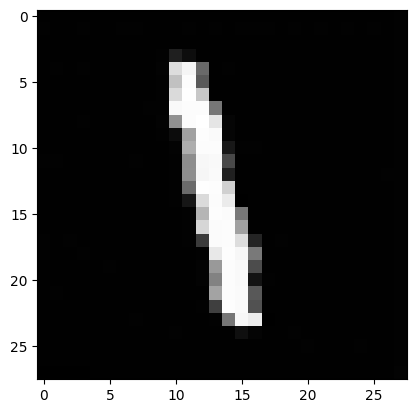

In [35]:
# show a random one
random_index = 50
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

We create a GIF of denoising process

MovieWriter ffmpeg unavailable; using Pillow instead.


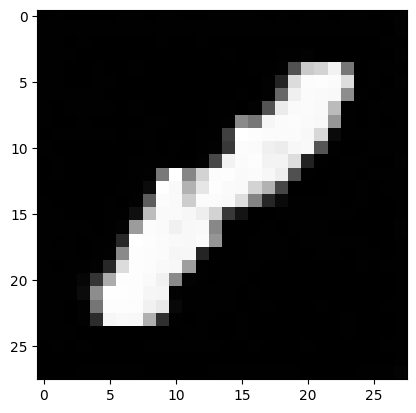

In [36]:
import matplotlib.animation as animation

random_index = 10

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()